# Solving the Cauchy-Euler Equation with a Neural Network in PyTorch

## The Cauchy-Euler Equation

The Cauchy-Euler equation (also known as the Euler-Cauchy equation) is a second-order linear homogeneous differential equation with variable coefficients. It has the general form:

$$
x^2 \frac{d^2 y}{dx^2} + \alpha x \frac{dy}{dx} + \beta y = 0
$$

## Approach

Using a standard neural network to approximate the solution *y(x)* to the Cauchy-Euler equation. The network is trained on a dataset of (*x*, *y*) pairs, where *x* is the input and *y* is the corresponding solution. The Adam optimizer and the mean squared error (MSE) loss function are used to train the network.a y = 0

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Dataset Class
Defining a custom dataset class called `CauchyEulerDataset` that inherits from `torch.utils.data.Dataset`. This class will handle loading and preprocessing of the data:
- Loading the dataset from a `.mat` file.
- Extracting `x` and `y` values.
- Normalizing the `y` values using min-max scaling.


In [3]:
class CauchyEulerDataset(Dataset):
    def __init__(self, data_path):
        data = loadmat(data_path)
        self.x = torch.tensor(data['data'][:, 0], dtype=torch.float32).to(device)
        self.y = torch.tensor(data['data'][:, 1], dtype=torch.float32).to(device)

        # Normalizing y values using min-max scaling (0 to 1)
        self.y_min = self.y.min()
        self.y_max = self.y.max()
        self.y = (self.y - self.y_min) / (self.y_max - self.y_min)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # Returning x and y values as a tuple
        return self.x[idx].unsqueeze(0), self.y[idx].unsqueeze(0)

## Loading the Dataset
In this cell, our dataset is being loaded using the `CauchyEulerDataset` class which was just defined. The dataset is split into training and testing sets (80% for training and 20% for testing).

In [4]:
data_path = 'cauchy_euler_dataset.mat' 
dataset = CauchyEulerDataset(data_path)

# Splitting the dataset into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

## Creating DataLoaders
Here, we create data loaders for both the training and testing datasets. Data loaders help in batching the data, shuffling, and parallel loading of data


In [5]:
# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Checking the data
for x_batch, y_batch in train_loader:
    print(f"x_batch: {x_batch[:5]}, y_batch: {y_batch[:5]}")
    break  

x_batch: tensor([[ 7.9883],
        [12.9085],
        [13.0081],
        [19.5618],
        [18.5259]]), y_batch: tensor([[0.1173],
        [0.2169],
        [0.2307],
        [0.2846],
        [0.0469]])


## Defining the Neural NetworkThe following cell contains  the neural network architecture in the `CauchyEulerNN` class. This model consists of:
- An input layer.
- Three hidden layers, each followed by a Tanh activation function.
- An output layer that provides the predicted `y` value based on the input `.



In [6]:
class CauchyEulerNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(CauchyEulerNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

## Initializing the Model
In this cell, an instance of our `CauchyEulerNN` modelis initialized  and movdt to th  devic)


In [7]:
model = CauchyEulerNN().to(device)
print(model)

CauchyEulerNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


## Defining Loss Function and OptimizerTthe loss functionis defined  as Mean Squared Error (MSE) and the Adam optimizeris used  for updating the model weights during training


In [8]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training parameters
Here, we define the number of epochs and batch size


In [9]:
epochs = 5000
batch_size = 128

# Training Loop
In this cell, the training loop for our model is implemented. During each epoch, 
1. The model is set to training mode.
2. Iterations are done through the training data in batches.
3. A forward pass is performed to get predictions.
4. The loss is calculated.
5. A backward pass is performed and the model weights are updated.
6. The average loss is printed every 100 epochs.


In [10]:
# Initializing a list to store loss values
loss_values = []

# This is the training loop
for epoch in range(epochs):
    #model set to train mode
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        # Forward pass
        y_pred = model(x_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track running loss
        running_loss += loss.item()

    # Calculating average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)  # Store the loss value

    # Printing average loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}")

Epoch [100/5000], Loss: 0.006206
Epoch [200/5000], Loss: 0.006140
Epoch [300/5000], Loss: 0.006239
Epoch [400/5000], Loss: 0.006015
Epoch [500/5000], Loss: 0.006167
Epoch [600/5000], Loss: 0.005924
Epoch [700/5000], Loss: 0.005991
Epoch [800/5000], Loss: 0.006060
Epoch [900/5000], Loss: 0.005783
Epoch [1000/5000], Loss: 0.005875
Epoch [1100/5000], Loss: 0.005741
Epoch [1200/5000], Loss: 0.005826
Epoch [1300/5000], Loss: 0.005716
Epoch [1400/5000], Loss: 0.005528
Epoch [1500/5000], Loss: 0.005506
Epoch [1600/5000], Loss: 0.005497
Epoch [1700/5000], Loss: 0.005397
Epoch [1800/5000], Loss: 0.005373
Epoch [1900/5000], Loss: 0.005352
Epoch [2000/5000], Loss: 0.005289
Epoch [2100/5000], Loss: 0.004856
Epoch [2200/5000], Loss: 0.003142
Epoch [2300/5000], Loss: 0.002641
Epoch [2400/5000], Loss: 0.002114
Epoch [2500/5000], Loss: 0.000111
Epoch [2600/5000], Loss: 0.000092
Epoch [2700/5000], Loss: 0.000116
Epoch [2800/5000], Loss: 0.000090
Epoch [2900/5000], Loss: 0.000078
Epoch [3000/5000], Loss

## Gathering all Predictions for Testing
After training is complete  the modelis switched  to evaluation mode and predictions for the test datase are gatheredt The  predictionsare then compared  against the true values to calculate our accuracy metrics


In [11]:
# Setting the model to evaluation mode
model.eval()  
with torch.no_grad():
    x_test_vals = test_dataset.dataset.x[test_dataset.indices].cpu().numpy()
    y_test_true = test_dataset.dataset.y[test_dataset.indices].cpu().numpy()
    y_test_pred = model(torch.tensor(x_test_vals, dtype=torch.float32).unsqueeze(1).to(device)).cpu().numpy()

## Calculating Accuracy MetricsVvarious metrics to evaluate the model's performanceare calculated  on the test set:
- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)
- R-squared (R²) score
Finarint the results of these me are printedtrics.


In [12]:
# Calculating Mean Squared Error for accuracy
accuracy = np.mean((y_test_true - y_test_pred) ** 2)
print(f"Test Mean Squared Error: {accuracy:.6f}")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_true, y_test_pred)
mae = mean_absolute_error(y_test_true, y_test_pred)
r_squared = r2_score(y_test_true, y_test_pred)

print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"R-squared: {r_squared:.6f}")

Test Mean Squared Error: 0.021086
Mean Squared Error: 0.000639
Mean Absolute Error: 0.006571
R-squared: 0.946823


## Plotting Loss Function
After training is complete, the collected loss values against the number of epochsare plotted  to visualize how the loss decreased over time. This helpstos understand the model's learning process


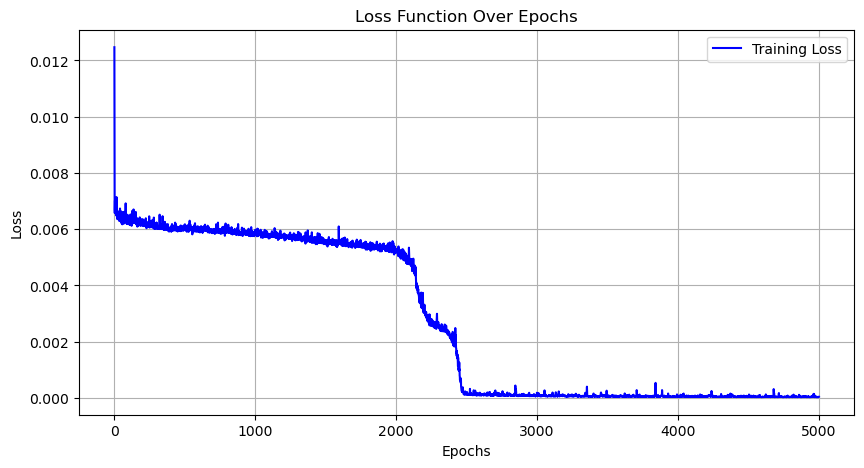

In [13]:
# Plotting the loss function
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_values, color='blue', label='Training Loss')
plt.title('Loss Function Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()